In [ ]:
import pandas as pd
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals
import seaborn as sns
from qiskit.circuit.library import EfficientSU2
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import ZZFeatureMap

In [2]:
def load_data_from_mongo(sample_limit=None,
                        num_labels=None,
                        uri="mongodb://localhost:27017/", 
                        db_name="Doodle_Classifier", 
                        collection_name="Filtered_Features",
                        ):
    try:
        client = MongoClient(uri)
        collection = client[db_name][collection_name]

        data = []
        
        # Get unique labels first
        all_unique_labels = collection.distinct("label")
        
        # Determine which labels to use
        if num_labels:
            if num_labels > len(all_unique_labels):
                print(f"Warning: Requested {num_labels} labels but only {len(all_unique_labels)} available")
                labels_to_use = all_unique_labels
            else:
                # Take first num_labels (you could randomize this if needed)
                labels_to_use = all_unique_labels[:num_labels]
                print(f"Using {num_labels} labels out of {len(all_unique_labels)} available")
        else:
            labels_to_use = all_unique_labels
            
        print(f"Selected labels: {labels_to_use}")
        
        if sample_limit:
            samples_per_label = sample_limit // len(labels_to_use)
            
            print(f"Found {len(all_unique_labels)} total unique labels")
            print(f"Using {len(labels_to_use)} labels")
            print(f"Sampling {samples_per_label} samples per label")
            
            # Sample equally from each selected label
            for label in labels_to_use:
                cursor = collection.find({"label": label}).limit(samples_per_label)
                for doc in cursor:
                    row = {
                        'label': doc["label"],
                        **doc["features"]
                    }
                    data.append(row)
        else:
            # Load all data for selected labels
            cursor = collection.find({"label": {"$in": labels_to_use}})
            for doc in cursor:
                row = {
                    'label': doc["label"],
                    **doc["features"]
                }
                data.append(row)
        
        client.close()
        
        if not data:
            raise ValueError("No data found in the collection")
            
        df = pd.DataFrame(data)
        X = df.drop(columns=['label']).values.astype(float)
        y = df['label'].values
        
        # Print label distribution
        unique_labels_loaded = np.unique(y, return_counts=True)
        print(f"Loaded {len(X)} samples with {X.shape[1]} features")
        print("Label distribution:")
        for label, count in zip(unique_labels_loaded[0], unique_labels_loaded[1]):
            print(f"  {label}: {count} samples")
            
        return X, y, df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

In [3]:
X,y,df = load_data_from_mongo(sample_limit=1000,num_labels=2)

features_X = StandardScaler().fit_transform(X)
features = features_X

labels = y

Using 2 labels out of 8 available
Selected labels: ['bicycle', 'car']
Found 8 total unique labels
Using 2 labels
Sampling 500 samples per label
Loaded 1000 samples with 19 features
Label distribution:
  bicycle: 500 samples
  car: 500 samples


In [4]:
# Min Max plot
# features_minmax = MinMaxScaler().fit_transform(X)

# df = pd.DataFrame(features_minmax, columns=[f"feature_{i}" for i in range(features_minmax.shape[1])])
# df["class"] = pd.Series(labels)

# sns.pairplot(df, hue="class", palette="tab10")
# # save the plot as a image
# import matplotlib.pyplot as plt

# plt.savefig("MinMax_pairplot800.png")

In [5]:
# Standard Scalar
# features_standard = StandardScaler().fit_transform(X)

# df = pd.DataFrame(features_standard, columns=[f"feature_{i}" for i in range(features_standard.shape[1])])
# df["class"] = pd.Series(labels)

# sns.pairplot(df, hue="class", palette="tab10")
# save the plot as a image
# plt.savefig("StandardScaler_pairplot800.png")

In [6]:
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [7]:
svc = SVC()
svc.fit(train_features, train_labels)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.91
Classical SVC on the test dataset:     0.86


Number of features: 5


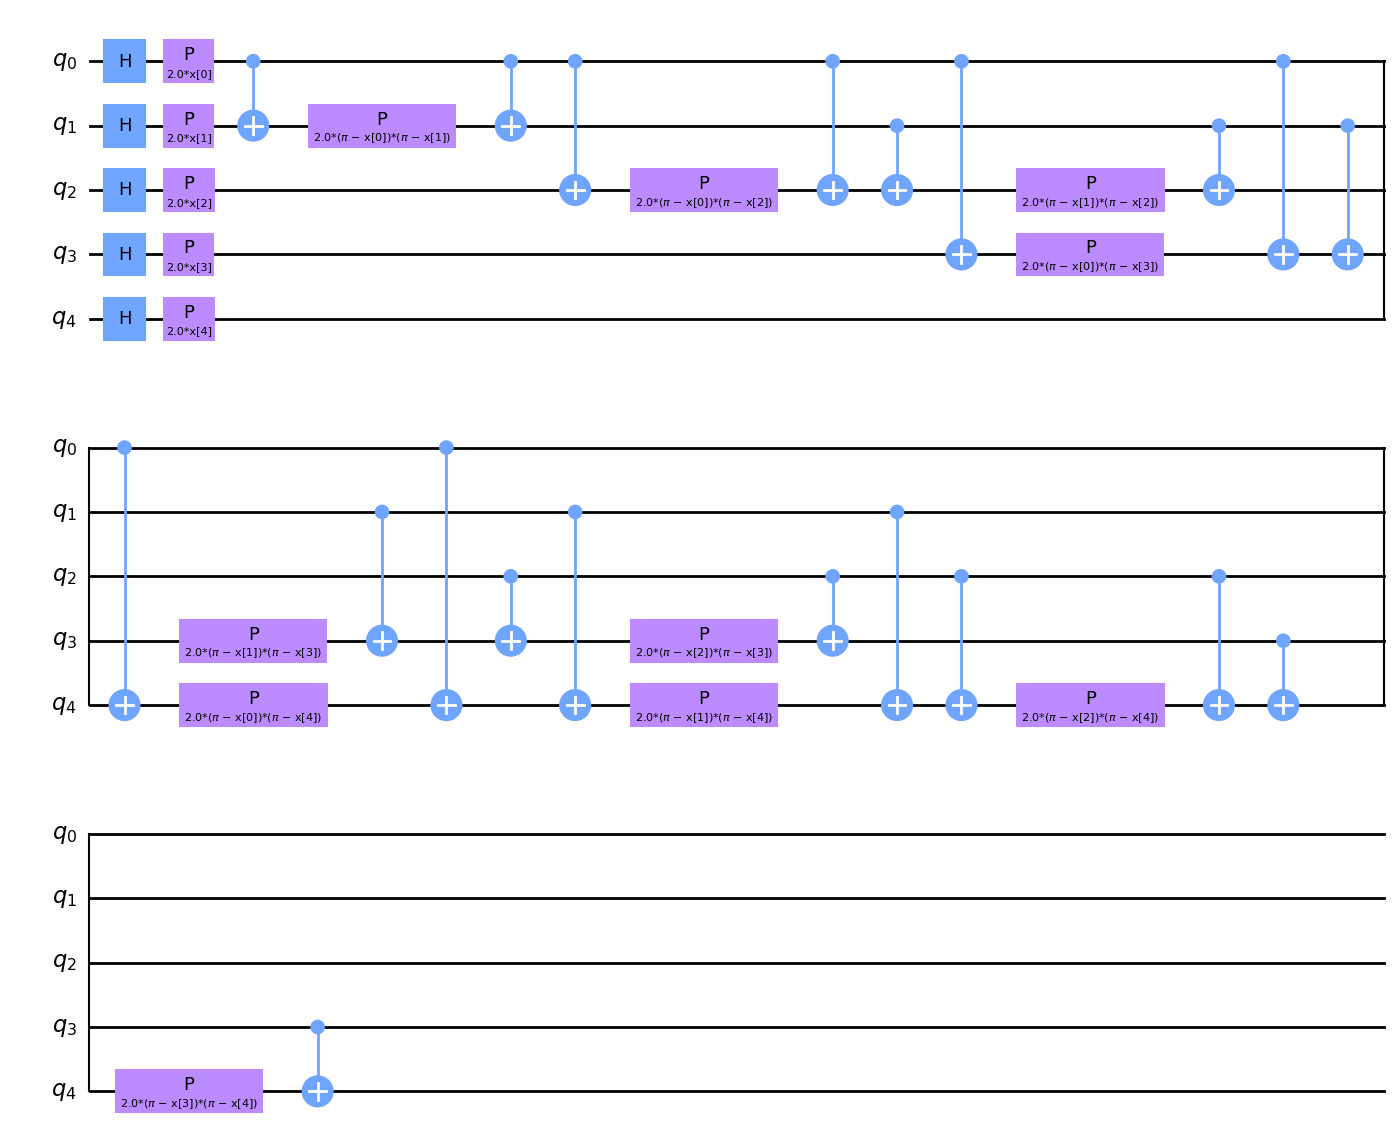

In [ ]:
num_features = features.shape[1]    
print(f"Number of features: {num_features}")

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

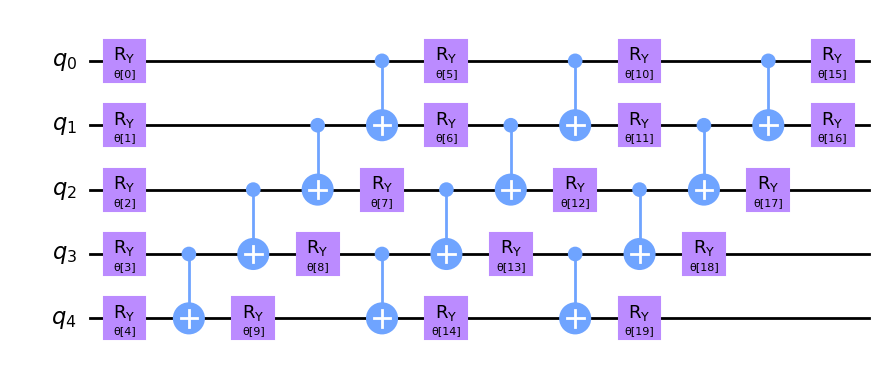

In [24]:

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [11]:

# optimizer = COBYLA(maxiter=100)

In [12]:

# sampler = Sampler()

In [13]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:

# vqc = VQC(
#     sampler=sampler,
#     feature_map=feature_map,
#     ansatz=ansatz,
#     optimizer=optimizer,
#     callback=callback_graph,
# )

# # clear objective value history
# objective_func_vals = []

# start = time.time()
# vqc.fit(train_features, train_labels)
# elapsed = time.time() - start

# print(f"Training time: {round(elapsed)} seconds")


In [15]:
# train_score_q4 = vqc.score(train_features, train_labels)
# test_score_q4 = vqc.score(test_features, test_labels)

# print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
# print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

<Axes: >

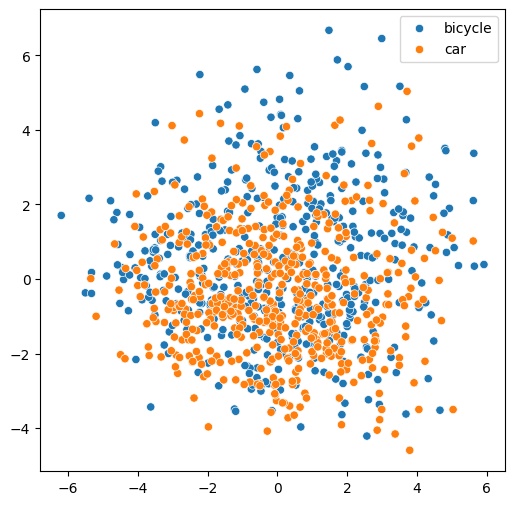

In [ ]:
components = 5
features = PCA(n_components=components).fit_transform(features_X)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [17]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [18]:
def train_svc_model(train_features, train_labels, test_features, test_labels,components=3):
    svc = SVC()
    svc.fit(train_features, train_labels)

    train_score_c2 = svc.score(train_features, train_labels)
    test_score_c2 = svc.score(test_features, test_labels)

    print(f"Classical SVC (after PCA with {components} components) on the training dataset: {train_score_c2:.2f}")
    print(f"Classical SVC (after PCA with {components} components) on the test dataset:     {test_score_c2:.2f}")

In [ ]:
def train_vqc_model(train_features, train_labels, test_features, test_labels,feature_map,ansatz=None, ansatz_reps=3, maxiter=40, callback_graph=callback_graph):

    num_features = train_features.shape[1]
    sampler = Sampler()

    print(f"Number of features: {num_features}")


    if feature_map is None:
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    
    if ansatz is None:
        ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)

    optimizer = COBYLA(maxiter=maxiter)

    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )

    # clear objective value history
    objective_func_vals = []

    # make the objective function plot look nicer.
    plt.rcParams["figure.figsize"] = (12, 6)


    start = time.time()
    vqc.fit(train_features, train_labels)
    elapsed = time.time() - start

    print(f"Training time: {round(elapsed)} seconds")
    
    train_score_q2_ra = vqc.score(train_features, train_labels)
    test_score_q2_ra = vqc.score(test_features, test_labels)
    
    return train_score_q2_ra, test_score_q2_ra   

In [20]:
train_svc_model(train_features, train_labels, test_features, test_labels,components=components)

Classical SVC (after PCA with 5 components) on the training dataset: 0.84
Classical SVC (after PCA with 5 components) on the test dataset:     0.82


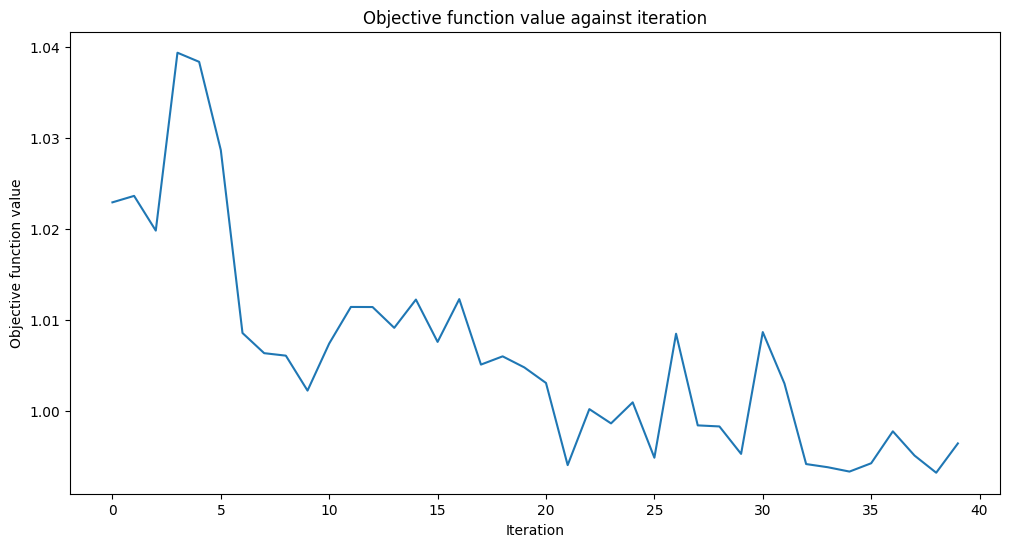

Training time: 190 seconds
Quantum VQC (after PCA with 5 components) on the training dataset using RealAmplitudes: 0.54
Quantum VQC (after PCA with 5 components) on the test dataset using RealAmplitudes:     0.49


In [21]:
train_score_q2_ra, test_score_q2_ra = train_vqc_model(train_features, train_labels, test_features, test_labels)
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

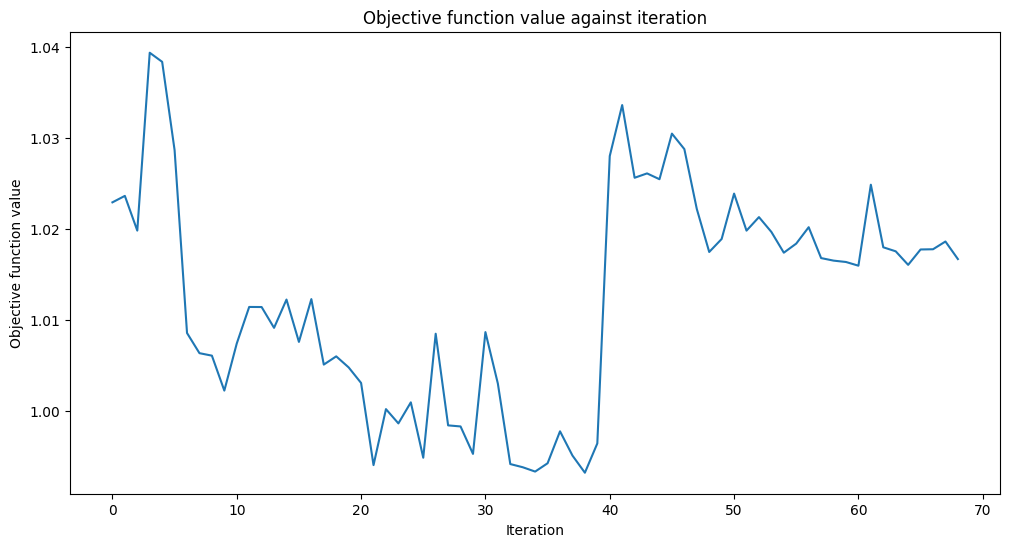

KeyboardInterrupt: 

In [22]:
num_features = train_features.shape[1]
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

train_score_q2_ra, test_score_q2_ra = train_vqc_model(train_features, train_labels, test_features, test_labels, ansatz=ansatz)
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using EfficientSU2: {train_score_q2_ra:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using EfficientSU2:     {test_score_q2_ra:.2f}")

<Axes: >

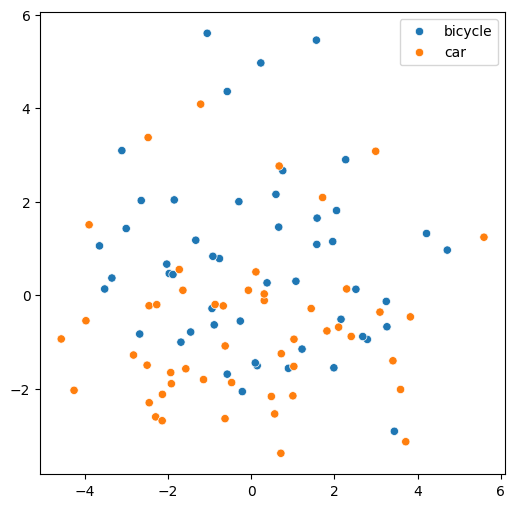

In [ ]:
components = 2
features = PCA(n_components=components).fit_transform(features_X)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [ ]:
train_svc_model(train_features, train_labels, test_features, test_labels,components=components)

Classical SVC (after PCA with 2 components) on the training dataset: 0.61
Classical SVC (after PCA with 2 components) on the test dataset:     0.65


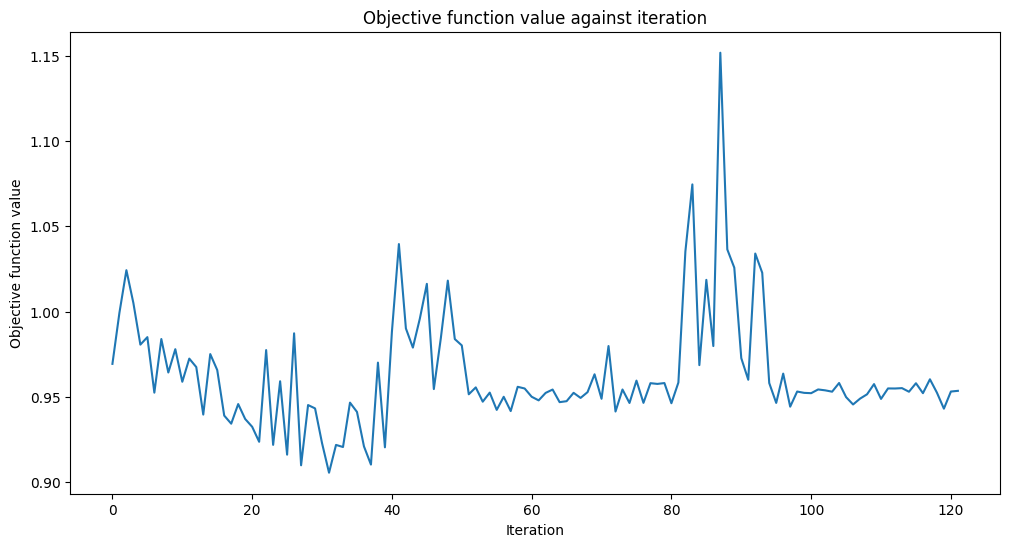

Training time: 14 seconds
Quantum VQC (after PCA with 2 components) on the training dataset using RealAmplitudes: 0.64
Quantum VQC (after PCA with 2 components) on the test dataset using RealAmplitudes:     0.55


In [ ]:
train_score_q2_ra, test_score_q2_ra = train_vqc_model(train_features, train_labels,test_features, test_labels)
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

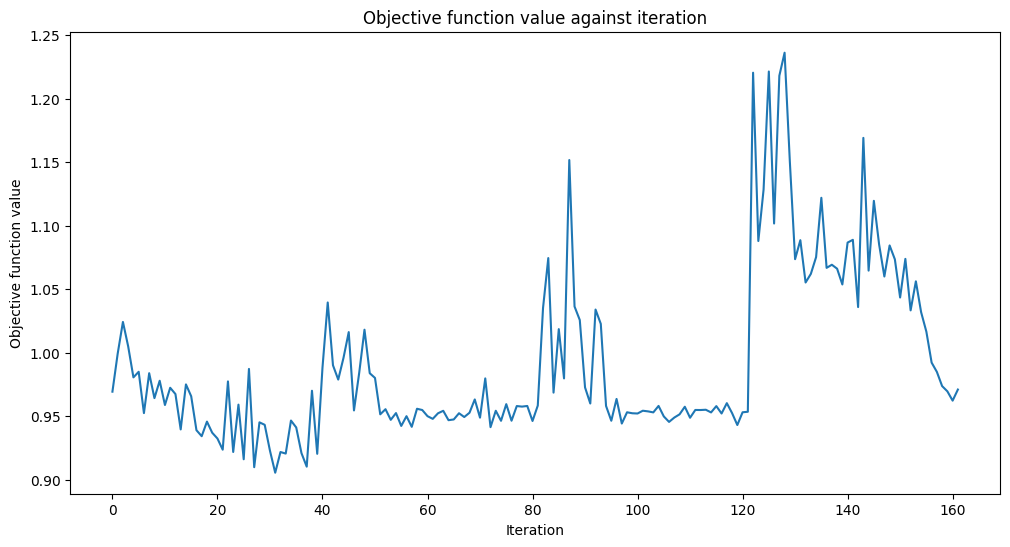

Training time: 15 seconds
Quantum VQC (after PCA with 2 components) on the training dataset using EfficientSU2: 0.57
Quantum VQC (after PCA with 2 components) on the test dataset using EfficientSU2:     0.45


In [ ]:
num_features = train_features.shape[1]
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

train_score_q2_ra, test_score_q2_ra = train_vqc_model(train_features, train_labels, test_features, test_labels, ansatz=ansatz)
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using EfficientSU2: {train_score_q2_ra:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using EfficientSU2:     {test_score_q2_ra:.2f}")